In [27]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import takewhile
from astropy.table import Table, join

# 1) Load COSMOSSNAP catalog

In [28]:
def read_cosmossnap_photometry_file(filename):
    # Get column names from header
    with open(filename, 'r') as fobj:
        headiter = takewhile(lambda s: s.startswith('#'), fobj)
        colnames = [elem.split()[2] for elem in headiter]
    # Open with pandas
    photometry = pd.read_csv(filename, delim_whitespace=True, comment="#", names=colnames)
    return photometry

In [29]:
filename = "../data/2016-06-22_cosmossnap_photometry.out"
%time photometry = read_cosmossnap_photometry_file(filename)

CPU times: user 17.6 s, sys: 1.43 s, total: 19 s
Wall time: 19.1 s


# 2) Applying sensible cuts for the Euclid scientific analysis

## Check redshift range where the H$\alpha$ line is in NISP's wavelength range

In [31]:
halpha_mask = (photometry["Lambda_Ha"] > 12500) & (photometry["Lambda_Ha"] < 18500)
halpha_selection = photometry[halpha_mask]

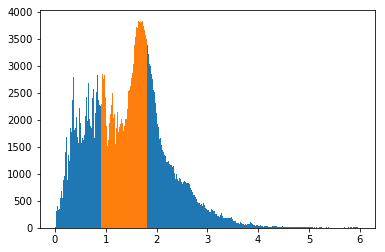

In [32]:
_ = plt.hist(photometry["z"], bins=np.arange(0, 6, 0.01))
_ = plt.hist(halpha_selection["z"], bins=np.arange(0, 6, 0.01))

In [33]:
print(halpha_selection["z"].min(), halpha_selection["z"].max())
print(len(halpha_selection))

0.9047 1.8188
241209


That's perfect, it corresponds to Anne Ealet's redshift presentation: her redshift selection is $0.9 < z < 1.8$. I will use the same redshift selection, which corresponds to the wavelength's observed by Euclid's spectrograph.

In [34]:
redshift_mask = (photometry["z"] > 0.9) & (photometry["z"] < 1.8)
photometry = photometry[redshift_mask]

# 3) Checking a few basic spectroscopic properties

In [35]:
ha_cols = [colname for colname in photometry.columns.values if (("_Ha" in colname) and ("Lambda" not in colname))]

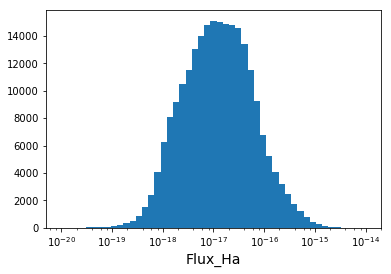

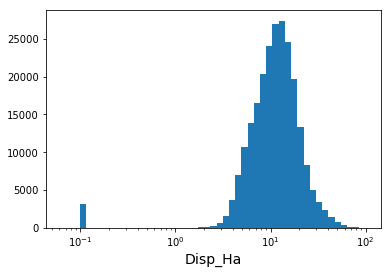

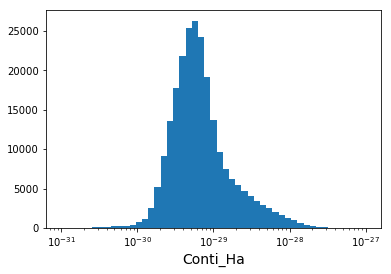

In [36]:
plt.figure()
_ = plt.hist(photometry["Flux_Ha"], bins=np.logspace(-20, -14, 50))
plt.xscale("log")
plt.xlabel("Flux_Ha", fontsize=14)

plt.figure()
_ = plt.hist(photometry["Disp_Ha"], bins=np.logspace(-1.2, 2, 50))
plt.xscale("log")
plt.xlabel("Disp_Ha", fontsize=14)

plt.figure()
_ = plt.hist(photometry["Conti_Ha"], bins=np.logspace(-31, -27, 50))
plt.xscale("log")
plt.xlabel("Conti_Ha", fontsize=14)

/Users/brunomor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


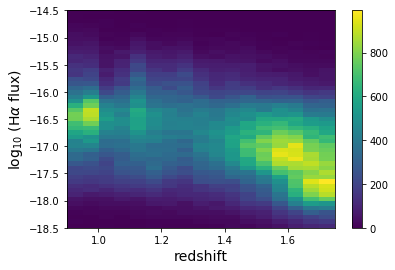

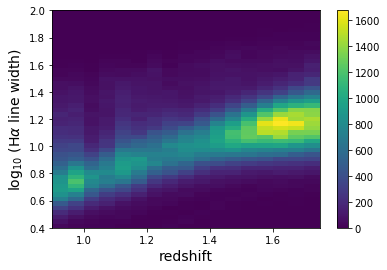

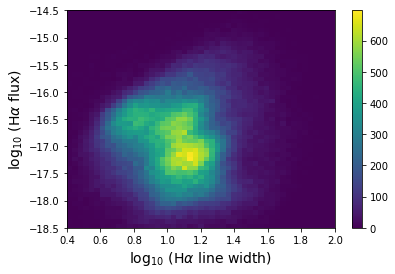

In [37]:
# There's a bug with matplotlib hist2d log scaling, transform the data to log before
log10_Flux_Ha = np.log10(photometry["Flux_Ha"])
log10_Disp_Ha = np.log10(photometry["Disp_Ha"])
plt.figure()
_ = plt.hist2d(photometry["z"], log10_Flux_Ha, bins=[np.arange(0.9, 1.8, 0.05), np.linspace(-18.5, -14.5, 50)])
plt.xlabel("redshift", fontsize=14)
plt.ylabel("$\log_{10}$ (H$\\alpha$ flux)", fontsize=14)
plt.colorbar()

plt.figure()
_ = plt.hist2d(photometry["z"], log10_Disp_Ha, bins=[np.arange(0.9, 1.8, 0.05), np.linspace(0.4, 2, 50)])
plt.xlabel("redshift", fontsize=14)
plt.ylabel("$\log_{10}$ (H$\\alpha$ line width)", fontsize=14)
plt.colorbar()

plt.figure()
_ = plt.hist2d(log10_Disp_Ha, log10_Flux_Ha, bins=[np.linspace(0.4, 2, 50), np.linspace(-18.5, -14.5, 50)])
plt.xlabel("$\log_{10}$ (H$\\alpha$ line width)", fontsize=14)
plt.ylabel("$\log_{10}$ (H$\\alpha$ flux)", fontsize=14)
plt.colorbar()

# 4) Matching catalog to spectroscopic data

In [38]:
phot_astropy = Table.from_pandas(photometry)

In [39]:
tips = Table.read("/Users/brunomor/Desktop/temp_work/tips_wide_allnans.csv", names=["Id", "nans"])
tips = tips[tips["nans"] == 0]
tips_phot = join(tips, phot_astropy)

In [41]:
print(len(tips_phot), len(photometry))

43713 235775


<span style="color:red">Only ~20% of the objects have spectra from TIPS. The remaining TIPS spectra were all NaNs. I investigated the issue carefully, and this is not a bug. The explanation is that when TIPS simulates the 2D slitless image for very faint galaxies, they end up not being detected. This is physically reasonable.</span>

Let's compare the properties of the detected objects below.

# 5) Recheck all properties as above

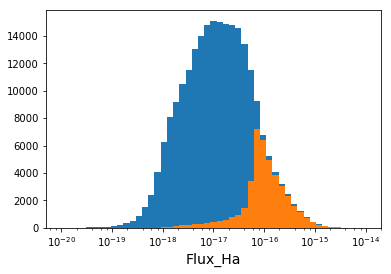

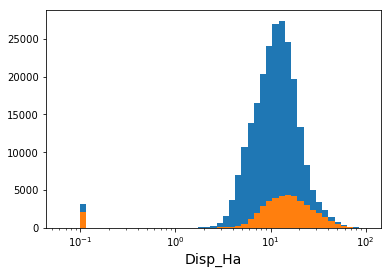

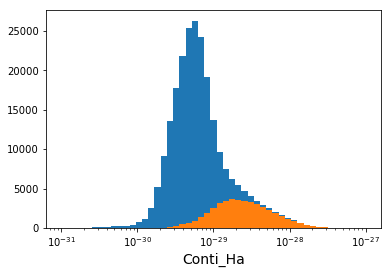

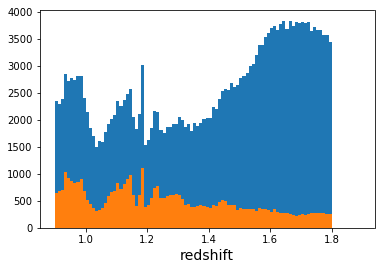

In [48]:
plt.figure()
_ = plt.hist(photometry["Flux_Ha"], bins=np.logspace(-20, -14, 50))
_ = plt.hist(tips_phot["Flux_Ha"], bins=np.logspace(-20, -14, 50))
plt.xscale("log")
plt.xlabel("Flux_Ha", fontsize=14)

plt.figure()
_ = plt.hist(photometry["Disp_Ha"], bins=np.logspace(-1.2, 2, 50))
_ = plt.hist(tips_phot["Disp_Ha"], bins=np.logspace(-1.2, 2, 50))
plt.xscale("log")
plt.xlabel("Disp_Ha", fontsize=14)

plt.figure()
_ = plt.hist(photometry["Conti_Ha"], bins=np.logspace(-31, -27, 50))
_ = plt.hist(tips_phot["Conti_Ha"], bins=np.logspace(-31, -27, 50))
plt.xscale("log")
plt.xlabel("Conti_Ha", fontsize=14)

plt.figure()
_ = plt.hist(photometry["z"], bins=np.arange(0.9, 1.9, 0.01))
_ = plt.hist(tips_phot["z"], bins=np.arange(0.9, 1.9, 0.01))
plt.xlabel("redshift", fontsize=14)

For completeness, check the 2D histograms as before.

/Users/brunomor/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


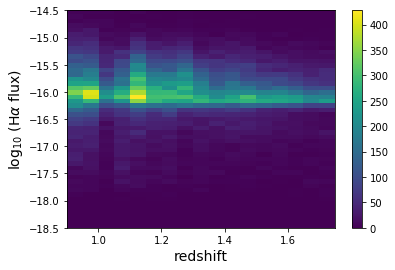

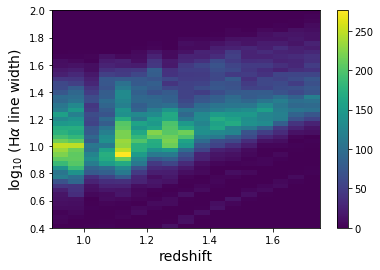

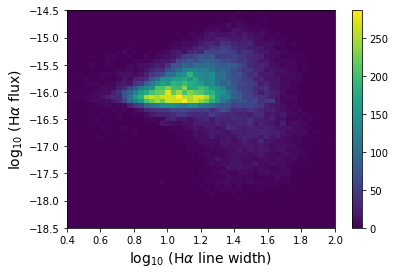

In [49]:
# There's a bug with matplotlib hist2d log scaling, transform the data to log before
log10_Flux_Ha = np.log10(tips_phot["Flux_Ha"])
log10_Disp_Ha = np.log10(tips_phot["Disp_Ha"])
plt.figure()
_ = plt.hist2d(tips_phot["z"], log10_Flux_Ha, bins=[np.arange(0.9, 1.8, 0.05), np.linspace(-18.5, -14.5, 50)])
plt.xlabel("redshift", fontsize=14)
plt.ylabel("$\log_{10}$ (H$\\alpha$ flux)", fontsize=14)
plt.colorbar()

plt.figure()
_ = plt.hist2d(tips_phot["z"], log10_Disp_Ha, bins=[np.arange(0.9, 1.8, 0.05), np.linspace(0.4, 2, 50)])
plt.xlabel("redshift", fontsize=14)
plt.ylabel("$\log_{10}$ (H$\\alpha$ line width)", fontsize=14)
plt.colorbar()

plt.figure()
_ = plt.hist2d(log10_Disp_Ha, log10_Flux_Ha, bins=[np.linspace(0.4, 2, 50), np.linspace(-18.5, -14.5, 50)])
plt.xlabel("$\log_{10}$ (H$\\alpha$ line width)", fontsize=14)
plt.ylabel("$\log_{10}$ (H$\\alpha$ flux)", fontsize=14)
plt.colorbar()

# 5) Selecting columns, renaming and saving file

In [50]:
tips_phot = tips_phot.to_pandas()
euclid = tips_phot[["Id", "SpcExt", "z", "Flux_Ha", "Disp_Ha", "Conti_Ha", "Lambda_Ha"]]
euclid.rename(columns={"z": "redshift"}, inplace=True)

In [51]:
euclid.to_csv("../data/2018-01-04_Euclid_photometry_matched2tips.csv", index=False)

In [52]:
len(euclid)

43713

# 6) Appendix: Check H$\alpha$ properties for any weird stuff

# <span style="color:red"> -------------------------------------------------------------------------- </span>
## <span style="color:red">Some galaxies have 0 H$\alpha$ flux. What are those?</span>

In [53]:
halpha_zero = photometry[photometry["Flux_Ha"] == 0]

In [54]:
halpha_zero

,Id,SpcExt,type,Mod,z,E(B-V),DMz,MNUV,Mstar,Half_light_radius,...,Conti_NII,Disp_NII,Lambda_SIIa,Flux_SIIa,Conti_SIIa,Disp_SIIa,Lambda_SIIb,Flux_SIIb,Conti_SIIb,Disp_SIIb
146,259499,101,1,3,1.2217,0.0,44.6397,-17.6333,10.55610,5.29880,...,5.546640e-29,0.1,14923.2,0.0,5.761170e-29,0.1,14954.3,0.0,5.769920e-29,0.1
202,259808,169,1,5,1.2082,0.0,44.6098,-17.9675,10.87270,9.93417,...,1.192030e-28,0.1,14832.5,0.0,1.229080e-28,0.1,14863.4,0.0,1.230790e-28,0.1
228,259940,170,1,5,1.2468,0.0,44.6943,-17.7120,9.91566,6.76264,...,1.308460e-28,0.1,15091.8,0.0,1.349130e-28,0.1,15123.2,0.0,1.351010e-28,0.1
239,260009,264,1,8,1.6228,0.0,45.4012,-15.8573,8.63783,2.71676,...,2.938870e-29,0.1,17617.3,0.0,2.976320e-29,0.1,17654.1,0.0,2.978420e-29,0.1
533,261125,69,1,2,0.9566,0.0,43.9827,-16.8671,10.15720,4.93703,...,4.244000e-29,0.1,13142.5,0.0,4.423130e-29,0.1,13169.9,0.0,4.430230e-29,0.1
683,261566,266,1,8,1.7603,0.0,45.6186,-15.4180,10.07260,1.85338,...,3.512880e-29,0.1,18540.9,0.0,3.557640e-29,0.1,18579.6,0.0,3.560160e-29,0.1
699,261644,132,1,4,0.9855,0.0,44.0625,-17.1387,10.66520,7.93584,...,1.075160e-28,0.1,13336.6,0.0,1.112290e-28,0.1,13364.4,0.0,1.114000e-28,0.1
969,262411,105,1,3,1.5072,0.0,45.2034,-19.3416,11.37320,24.40130,...,2.071410e-28,0.1,16840.9,0.0,2.151530e-28,0.1,16876.0,0.0,2.154800e-28,0.1
1357,263608,228,1,7,0.9592,0.0,43.9899,-14.8318,9.97372,4.22839,...,1.589490e-29,0.1,13159.9,0.0,1.623980e-29,0.1,13187.4,0.0,1.626120e-29,0.1
1806,265180,175,1,5,1.1921,0.0,44.5738,-17.9721,11.00540,5.18172,...,1.307540e-28,0.1,14724.3,0.0,1.348180e-28,0.1,14755.0,0.0,1.350060e-28,0.1


Ha! They are all ellipticals (i.e. Mod < 8). No emission lines in those guys. Keep them in the data, but expect the failure rate to be high for them.

In [55]:
del halpha_zero

## <span style="color:red">Some galaxies have very small H$\alpha$ line width. What are those?</span>

In [56]:
halpha_smalldisp = photometry[photometry["Disp_Ha"] < 1]

In [57]:
np.unique(halpha_smalldisp["Flux_Ha"])

array([  0.00000000e+00,   1.20942000e-21,   1.30914000e-20,
         2.66355000e-20])

These are part of the same ones that have very small flux, same as above. Keep them, check performance on them later.

# <span style="color:red"> -------------------------------------------------------------------------- </span>